In [17]:
import os
import torch
import torchvision
import tarfile
import time 
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

In [18]:
# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

Using downloaded and verified file: .\cifar10.tgz


In [19]:
# Check if the target directory already contains the extracted files
if not os.path.exists('./data/cifar10'):
    # If not extracted, extract the files
    with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
        tar.extractall(path='./data')
else:
    print("CIFAR-10 dataset already extracted.")

CIFAR-10 dataset already extracted.


In [20]:
data_dir = './data/cifar10'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['test', 'train']
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [21]:
airplane_files = os.listdir(data_dir + "/train/airplane")
print('No. of training examples for airplanes:', len(airplane_files))
print(airplane_files[:5])

No. of training examples for airplanes: 5000
['0001.png', '0002.png', '0003.png', '0004.png', '0005.png']


In [22]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [23]:
dataset = ImageFolder(data_dir+'/train', transform=ToTensor())

In [24]:
import random

img, label = dataset[random.randint(0, len(dataset))]
print(img.shape, label)
img

torch.Size([3, 32, 32]) 7


tensor([[[0.9686, 0.9686, 0.9686,  ..., 0.8706, 0.8627, 0.8549],
         [0.9608, 0.9608, 0.9608,  ..., 0.4510, 0.4549, 0.4588],
         [0.9804, 0.9765, 0.9765,  ..., 0.3725, 0.3490, 0.3137],
         ...,
         [0.4314, 0.4314, 0.4353,  ..., 0.0078, 0.0078, 0.0118],
         [0.4078, 0.4275, 0.4706,  ..., 0.0000, 0.0000, 0.0000],
         [0.4314, 0.4157, 0.4353,  ..., 0.0941, 0.1216, 0.1882]],

        [[0.9686, 0.9686, 0.9686,  ..., 0.8784, 0.8706, 0.8627],
         [0.9608, 0.9608, 0.9608,  ..., 0.4510, 0.4588, 0.4627],
         [0.9804, 0.9765, 0.9765,  ..., 0.3451, 0.3216, 0.2863],
         ...,
         [0.4353, 0.4314, 0.4353,  ..., 0.3176, 0.3020, 0.2941],
         [0.4196, 0.4353, 0.4745,  ..., 0.3098, 0.3020, 0.3137],
         [0.4510, 0.4392, 0.4588,  ..., 0.2902, 0.3098, 0.3608]],

        [[0.9686, 0.9686, 0.9686,  ..., 0.8824, 0.8706, 0.8667],
         [0.9608, 0.9608, 0.9608,  ..., 0.4510, 0.4549, 0.4706],
         [0.9804, 0.9804, 0.9804,  ..., 0.3255, 0.2980, 0.

In [25]:
import matplotlib.pyplot as plt

def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  horse (7)


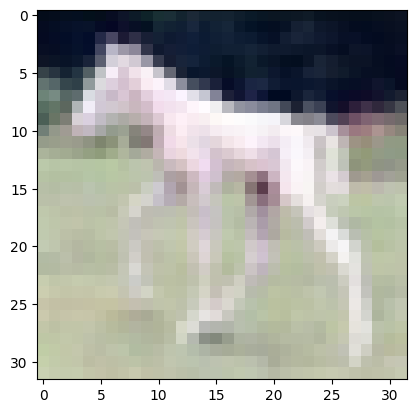

In [26]:
show_example(*dataset[random.randint(0, len(dataset))])

In [27]:
random_seed = 3407
torch.manual_seed(random_seed);

In [28]:
val_size = 5000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [29]:
from torch.utils.data.dataloader import DataLoader

batch_size=128

In [72]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

train_dl_cpu = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl_cpu = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

train_dl_gpu = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl_gpu = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

In [31]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

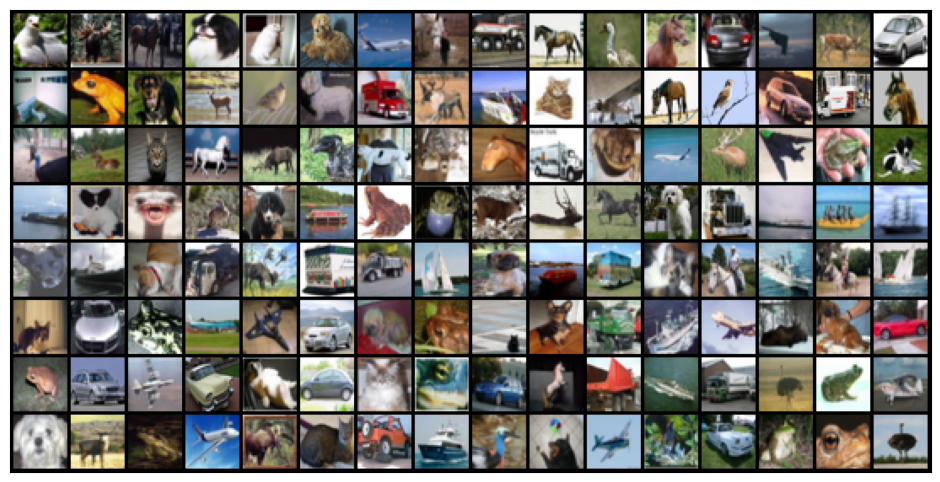

In [56]:
show_batch(train_dl)

In [33]:
import torch.nn as nn
import torch.nn.functional as F

In [34]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [35]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [36]:
model = Cifar10CnnModel()
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

In [37]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [38]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def move_to_device(train_dl, val_dl, model, device):
    train_dl = DeviceDataLoader(train_dl, device)
    val_dl = DeviceDataLoader(val_dl, device)
    model = to_device(model, device)
    return train_dl, val_dl, model

#TODO: notes about compaing CPU vs GPU (CUDA)

In [39]:
#Show available CUDA devices
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Available GPU devices:")
    for i in range(torch.cuda.device_count()):
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No CUDA available.")



Available GPU devices:
Device 0: NVIDIA GeForce RTX 2070 SUPER


In [57]:
# Common training parameters
num_epochs = 1
opt_func = torch.optim.Adam
lr = 0.001

# Use GPU (CUDA) for training if available
if torch.cuda.is_available():
    print("Training on GPU.")
    train_dl_gpu, val_dl_gpu, model_gpu = move_to_device(train_dl_gpu, val_dl_gpu, Cifar10CnnModel(), torch.device("cuda"))
    gpu_start_time = time.time()
    history_gpu = fit(num_epochs, lr, model_gpu, train_dl_gpu, val_dl_gpu, opt_func)
    gpu_end_time = time.time()
    print(f"GPU training took: {gpu_end_time - gpu_start_time} seconds.")



Training on GPU.
Epoch [0], train_loss: 1.8336, val_loss: 1.3906, val_acc: 0.4766
GPU training took: 29.48021650314331 seconds.


In [48]:
#empty cache
torch.cuda.empty_cache()
torch.xpu.empty_cache()


In [58]:
# Use CPU for training
print("Training on CPU.")
train_dl_cpu, val_dl_cpu, model_cpu = move_to_device(train_dl_cpu, val_dl_cpu, Cifar10CnnModel(), torch.device("cpu"))
cpu_start_time = time.time()
history_cpu = fit(num_epochs, lr, model_cpu, train_dl_cpu, val_dl_cpu, opt_func)
cpu_end_time = time.time()
print(f"CPU training took: {cpu_end_time - cpu_start_time} seconds.")

Training on CPU.
Epoch [0], train_loss: 1.7796, val_loss: 1.3752, val_acc: 0.4927
CPU training took: 467.58499455451965 seconds.


In [61]:
print(f"CUDA vs CPU training time comparison on CIFAR-10 dataset with {num_epochs} epoch(s):")
print(f"CPU training time: {cpu_end_time - cpu_start_time:.2f} seconds")
print(f"GPU training time: {gpu_end_time - gpu_start_time:.2f} seconds")
print(f"Speedup: {(cpu_end_time - cpu_start_time) / (gpu_end_time - gpu_start_time):.2f}x")
print("Difference: ", cpu_end_time - cpu_start_time - (gpu_end_time - gpu_start_time))

CUDA vs CPU training time comparison on CIFAR-10 dataset with 1 epoch(s):
CPU training time: 467.58 seconds
GPU training time: 29.48 seconds
Speedup: 15.86x
Difference:  438.10477805137634


In [ ]:
# BADANIE MODELU NA GPU

In [70]:
def plot_accuracies(history_cpu, history_gpu):
    accuracies_cpu = [x['val_acc'] for x in history_cpu]
    accuracies_gpu = [x['val_acc'] for x in history_gpu]
    plt.plot(accuracies_cpu, '-x', label='CPU')
    plt.plot(accuracies_gpu, '-o', label='GPU')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.legend();

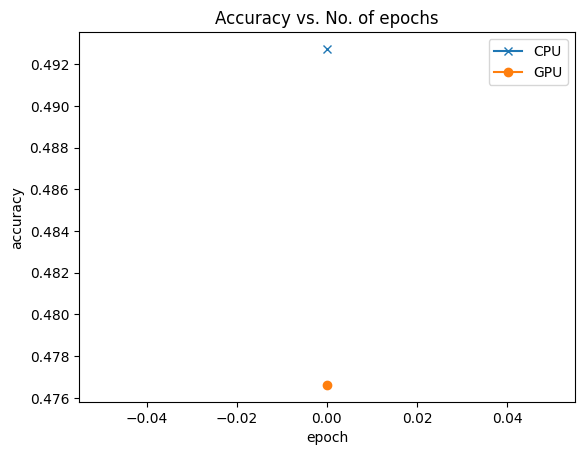

In [71]:
plot_accuracies(history_cpu,history_gpu)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [ ]:
plot_losses(history)

In [ ]:
test_dataset = ImageFolder(data_dir+'/test', transform=ToTensor())

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

In [ ]:
for i in range(5):
    img, label = test_dataset[i]
    plt.imshow(img.permute(1, 2, 0))
    print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))
    plt.show()

In [ ]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result